In [2]:
!pip install mesa numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 4.2 MB/s eta 0:00:00


# ESERCIZIO 2
How can we parameterize our model to replicate the results shown in figures 1, 2, 6 and 7 of Nowak et al. (1994a)?

**1) Obiettivo dell'esercizio**


L'obiettivo è osservare come **variano i comportamenti cooperativi** su una griglia spaziale al variare dei parametri **m e b** e al modificarsi a sua volta di alcune condizioni strutturali, come il tipo di aggiornamento o la presenza di self-matching.



*  il parametro **m regola quanto il guadagno influisca sulle decisioni**
*  il parametro  **b indica il beneficio di defezionare**



**2) Il codice**


Partiamo da un modello semplice: una griglia 40x40, con ogni cella occupata da un agente. Ogni agente gioca contro i suoi 8 vicini (quelli attorno a lui, comprese le diagonali) e anche contro sé stesso (self-matching attivo). Dopo aver calcolato il guadagno totale, l’agente decide se cambiare strategia, copiando quella di un vicino scelto a caso, usando la regola di imitazione Fermi: se un vicino ha guadagnato di più, può essere imitato con una certa probabilità che dipende dal parametro m (più è alto, più conta il guadagno nel decidere). Tutti gli agenti si aggiornano insieme (aggiornamento sincrono), e la simulazione dura 100 turni.
La figura risultante è una griglia con colori che indicano lo stato di ogni agente:

- **Blu**: l’agente era cooperatore e lo è rimasto

- **Rosso:** l’agente era defezionatore e lo è rimasto

- **Verde**: l’agente è passato da defezionatore a cooperatore


- **Giallo**: l’agente è passato da  cooperatore a defezionatore

Ogni riga del grafico corrisponde a un valore diverso di m, ogni colonna a un valore di b. Si possono osservare pattern spaziali e variazioni nella stabilità delle strategie.






**3) Risultati finali**
Il grafico finale mostra chiaramente come, al variare di m e b, cambiano le dinamiche tra cooperazione e defezione:


**Figura 1**: (griglia 40x40, 100 step, self-matching ON, aggiornamento sincrono)
È la simulazione base: tutti giocano anche contro sé stessi e aggiornano la strategia insieme.

- Le aree blu e rosse mostrano stabilità (cooperatori e defezionatori consolidati).

- I gialli e verdi sono presenti nelle zone intermedie: indicano dinamiche locali, dove gli agenti cambiano ancora strategia.

- In alto a sinistra (m alto, b basso) → quasi tutta blu: la cooperazione domina.

- In basso a destra (m basso, b alto) → tutto rosso: la defezione prende il sopravvento.





Simulazione (m=inf, b=1.05) completata in 1.7s
Simulazione (m=inf, b=1.13) completata in 2.1s
Simulazione (m=inf, b=1.16) completata in 3.0s
Simulazione (m=inf, b=1.35) completata in 1.8s
Simulazione (m=inf, b=1.42) completata in 2.0s
Simulazione (m=inf, b=1.55) completata in 1.8s
Simulazione (m=inf, b=1.71) completata in 1.8s
Simulazione (m=inf, b=1.77) completata in 1.8s
Simulazione (m=inf, b=1.9) completata in 2.8s
Simulazione (m=inf, b=2.01) completata in 2.4s
Simulazione (m=100, b=1.05) completata in 1.9s
Simulazione (m=100, b=1.13) completata in 1.9s
Simulazione (m=100, b=1.16) completata in 1.9s
Simulazione (m=100, b=1.35) completata in 1.8s
Simulazione (m=100, b=1.42) completata in 2.0s
Simulazione (m=100, b=1.55) completata in 3.6s
Simulazione (m=100, b=1.71) completata in 1.8s
Simulazione (m=100, b=1.77) completata in 2.3s
Simulazione (m=100, b=1.9) completata in 1.8s
Simulazione (m=100, b=2.01) completata in 2.2s
Simulazione (m=20, b=1.05) completata in 2.1s
Simulazione (m=2

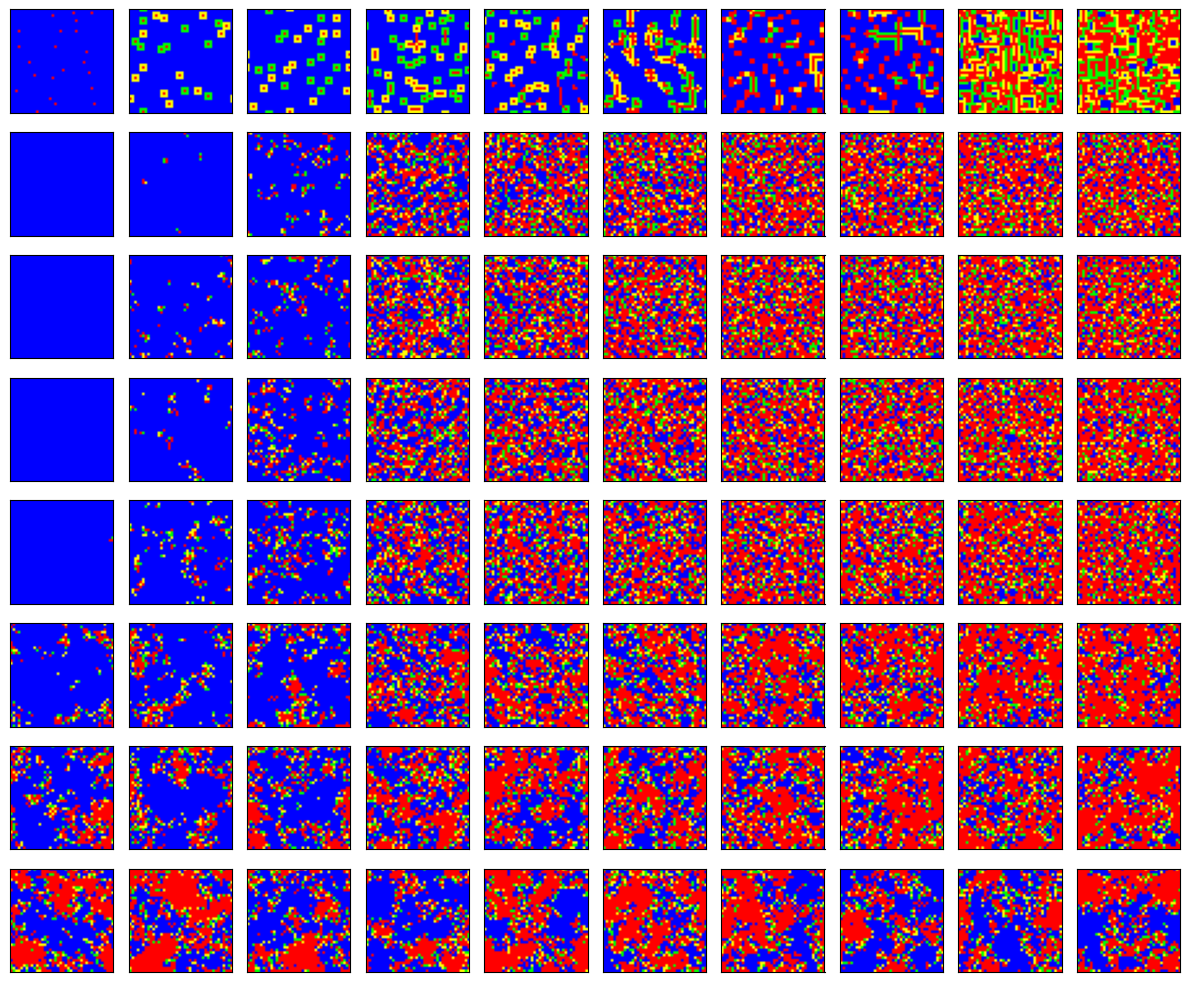

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import time
import warnings

from mesa import Agent, Model
from mesa.space import MultiGrid

warnings.filterwarnings("ignore", category=UserWarning)

# ---------- Payoff Matrix ----------
def snowdrift_payoff_matrix(b):
    return [[1, 1 - 1 / b], [b, 0]]

# ---------- Agent Definition ----------
class PatchAgent(Agent):
    def __init__(self, model, unique_id, pos):
        super().__init__(model)
        self.unique_id = unique_id
        self.pos = pos
        self.strategy = None
        self.strategy_after_revision = None
        self.payoff = 0
    #ad ogni turno interagisce con i suoi vicini (N=8) e anche con sè stesso (self-matching attivo)
    def compute_neighbors(self):
        self.my_coplayers = self.model.grid.get_neighbors(
            self.pos, moore=True, include_center=True, radius=1  # self-matching ON
        )
        self.n_of_my_coplayers = len(self.my_coplayers)
  #l'agente gioca, calcola il proprio guadagno
    def play(self):
        self.compute_neighbors()
        counts = [sum(1 for a in self.my_coplayers if a.strategy == i) for i in range(2)]
        my_payoffs = self.model.payoff_matrix[self.strategy]
        self.payoff = sum(p * c for p, c in zip(my_payoffs, counts))

       # Fase di revisione della strategia:
       # - Se m è infinito → l’agente copia la strategia del vicino con il payoff più alto (imitazione del migliore).
       # - Se m è finito → si applica la regola Fermi:
       #     • Si sceglie un vicino a caso (opp).
       #     • Si confrontano i payoff tra l’agente e il vicino.
       #     • Si calcola la probabilità di imitazione sulla base della differenza di payoff, normalizzata.
       #     • Con questa probabilità, l’agente decide se adottare la strategia del vicino o mantenere la propria.
    def update_strategy_after_revision(self):
        m = self.model.m
        if m == float('inf'):
            # Best neighbor imitation
            best = max(self.my_coplayers, key=lambda a: a.payoff)
            self.strategy_after_revision = best.strategy
        else:
            opp = random.choice(self.my_coplayers) if self.my_coplayers else self
            diff = (opp.payoff - self.payoff) / self.n_of_my_coplayers if self.n_of_my_coplayers else 0
            prob = 1 / (1 + math.exp(-m * diff))
            self.strategy_after_revision = opp.strategy if random.random() < prob else self.strategy

    def update_strategy(self):
        self.strategy = self.strategy_after_revision

# ---------- Model Definition ----------
## Crea la griglia, inizializza gli agenti e assegna casualmente le strategie iniziali.
# Ad ogni step, gli agenti giocano, valutano se cambiare strategia e si aggiornano.

class GameModel(Model):
    def __init__(self, width, height, payoff_matrix, initial_distribution, m):
        super().__init__()
        self.grid = MultiGrid(width, height, torus=True)
        self.patch_agents = []
        self.payoff_matrix = np.array(payoff_matrix)
        self.n_of_players = width * height
        self.m = m

        uid = 0
        for x in range(width):
            for y in range(height):
                agent = PatchAgent(self, uid, (x, y))
                self.grid.place_agent(agent, (x, y))
                self.patch_agents.append(agent)
                uid += 1
        self._setup_strategies(initial_distribution)

    def _setup_strategies(self, distribution):
        agents = self.patch_agents.copy()
        random.shuffle(agents)
        idx = 0
        for strat, count in enumerate(distribution):
            for _ in range(count):
                agents[idx].strategy = strat
                agents[idx].strategy_after_revision = strat
                idx += 1

    def step(self):
        for a in self.patch_agents:
            a.play()
        for a in self.patch_agents:
            a.update_strategy_after_revision()
        for a in self.patch_agents:
            a.update_strategy()

# ---------- Simulation Grid Generation ----------
#griglia 40 x 40
#100 steps
def generate_figure():
    width = height = 40
    steps = 100
    m_values = [float('inf'), 100, 20, 10, 5, 1, 0.5, 0]
    b_values = [1.05, 1.13, 1.16, 1.35, 1.42, 1.55, 1.71, 1.77, 1.9, 2.01]

    fig, axes = plt.subplots(len(m_values), len(b_values), figsize=(12, 10))

    for row, m in enumerate(m_values):
        for col, b in enumerate(b_values):
            start = time.time()
            matrix = snowdrift_payoff_matrix(b)
            distribution = [width * height // 2, width * height // 2]
            model = GameModel(width, height, matrix, distribution, m=m)

            for _ in range(steps):
                model.step()

            final = np.zeros((width, height))
            prev_strategies = {a.unique_id: a.strategy for a in model.patch_agents}
            model.step()
            prev = np.zeros((width, height))

            for agent in model.patch_agents:
                x, y = agent.pos
                final[x, y] = agent.strategy
                prev[x, y] = prev_strategies[agent.unique_id]
            #generata la figura, ogni riga diverso valore di m e ogni colonna diverso valore di b
            image = np.zeros((width, height, 3))
            for x in range(width):
                for y in range(height):
                    if final[x, y] == 0 and prev[x, y] == 0:
                        image[x, y] = [0, 0, 1]  # blue
                    elif final[x, y] == 1 and prev[x, y] == 1:
                        image[x, y] = [1, 0, 0]  # red
                    elif final[x, y] == 1 and prev[x, y] == 0:
                        image[x, y] = [0, 1, 0]  # green
                    elif final[x, y] == 0 and prev[x, y] == 1:
                        image[x, y] = [1, 1, 0]  # yellow

            ax = axes[row][col]
            ax.imshow(image.transpose((1, 0, 2)), origin='lower')
            ax.set_xticks([])
            ax.set_yticks([])
            print(f"Simulazione (m={m}, b={b}) completata in {time.time() - start:.1f}s")

    plt.tight_layout()
    plt.show()

# Run the full figure
generate_figure()






**Modifiche**


**Figura 2**: (griglia 80x80, 200 step, tutto identico alla 1 ma più grande e lunga)
Aumentare le dimensioni e la durata della simulazione non cambia il comportamento ma lo rende più visibile e leggibile.

- I **pattern diventano più puliti e maturi**: si distinguono bene le zone stabili da quelle instabili.

- Si nota meglio la transizione tra cooperazione e defezione lungo la diagonale della matrice.



Simulazione (m=inf, b=1.05) completata in 13.3s
Simulazione (m=inf, b=1.13) completata in 13.1s
Simulazione (m=inf, b=1.16) completata in 13.2s
Simulazione (m=inf, b=1.35) completata in 13.1s
Simulazione (m=inf, b=1.42) completata in 13.2s
Simulazione (m=inf, b=1.55) completata in 13.2s
Simulazione (m=inf, b=1.71) completata in 13.2s
Simulazione (m=inf, b=1.77) completata in 13.1s
Simulazione (m=inf, b=1.9) completata in 13.2s
Simulazione (m=inf, b=2.01) completata in 13.1s
Simulazione (m=100, b=1.05) completata in 13.0s
Simulazione (m=100, b=1.13) completata in 13.0s
Simulazione (m=100, b=1.16) completata in 13.0s
Simulazione (m=100, b=1.35) completata in 13.2s
Simulazione (m=100, b=1.42) completata in 13.2s
Simulazione (m=100, b=1.55) completata in 13.5s
Simulazione (m=100, b=1.71) completata in 13.5s
Simulazione (m=100, b=1.77) completata in 16.6s
Simulazione (m=100, b=1.9) completata in 13.4s
Simulazione (m=100, b=2.01) completata in 13.3s
Simulazione (m=20, b=1.05) completata in 1

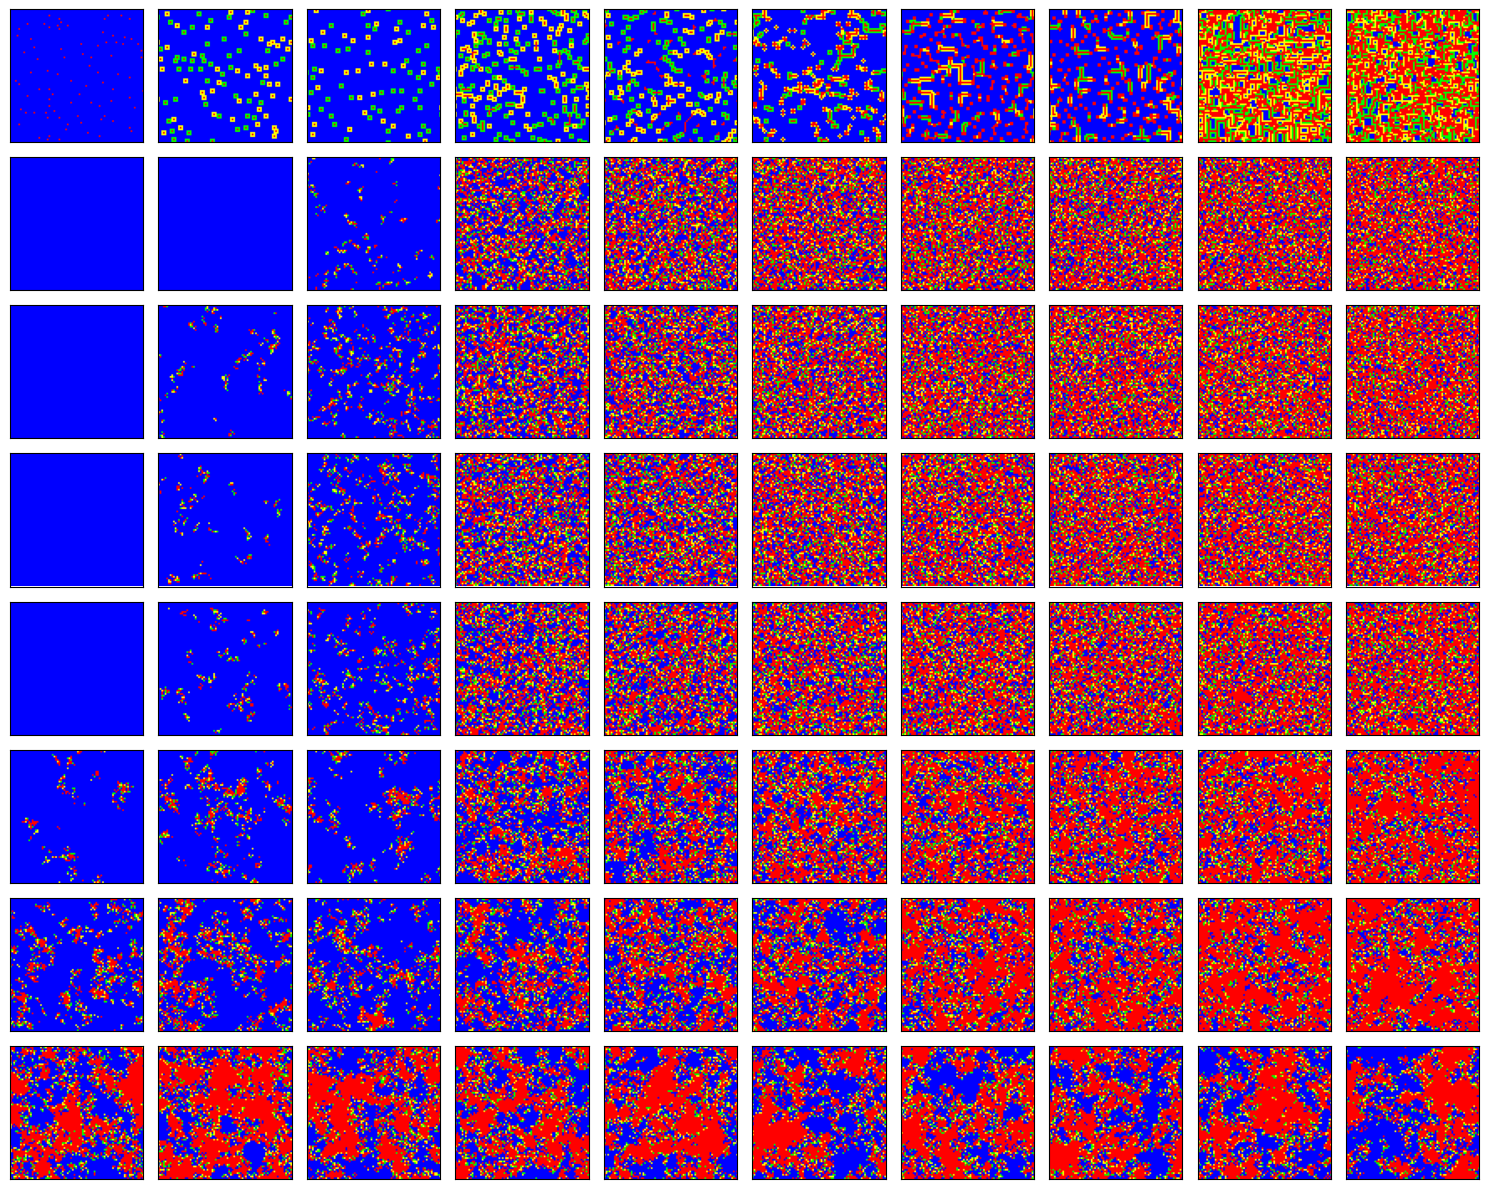

In [5]:
#figura 2
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import time
import warnings

from mesa import Agent, Model
from mesa.space import MultiGrid

warnings.filterwarnings("ignore", category=UserWarning)

# ---------- Payoff Matrix ----------
def snowdrift_payoff_matrix(b):
    return [[1, 1 - 1 / b], [b, 0]]

# ---------- Agent Definition ----------
class PatchAgent(Agent):
    def __init__(self, model, unique_id, pos):
        super().__init__(model)
        self.unique_id = unique_id
        self.pos = pos
        self.strategy = None
        self.strategy_after_revision = None
        self.payoff = 0

    def compute_neighbors(self):
        self.my_coplayers = self.model.grid.get_neighbors(
            self.pos, moore=True, include_center=True, radius=1  # SELF-MATCHING ON
        )
        self.n_of_my_coplayers = len(self.my_coplayers)

    def play(self):
        self.compute_neighbors()
        counts = [sum(1 for a in self.my_coplayers if a.strategy == i) for i in range(2)]
        my_payoffs = self.model.payoff_matrix[self.strategy]
        self.payoff = sum(p * c for p, c in zip(my_payoffs, counts))

    def update_strategy_after_revision(self):
        m = self.model.m
        if m == float('inf'):
            best = max(self.my_coplayers, key=lambda a: a.payoff)
            self.strategy_after_revision = best.strategy
        else:
            opp = random.choice(self.my_coplayers) if self.my_coplayers else self
            diff = (opp.payoff - self.payoff) / self.n_of_my_coplayers if self.n_of_my_coplayers else 0
            prob = 1 / (1 + math.exp(-m * diff))
            self.strategy_after_revision = opp.strategy if random.random() < prob else self.strategy

    def update_strategy(self):
        self.strategy = self.strategy_after_revision

# ---------- Model Definition ----------
class GameModel(Model):
    def __init__(self, width, height, payoff_matrix, initial_distribution, m):
        super().__init__()
        self.grid = MultiGrid(width, height, torus=True)
        self.patch_agents = []
        self.payoff_matrix = np.array(payoff_matrix)
        self.n_of_players = width * height
        self.m = m

        uid = 0
        for x in range(width):
            for y in range(height):
                agent = PatchAgent(self, uid, (x, y))
                self.grid.place_agent(agent, (x, y))
                self.patch_agents.append(agent)
                uid += 1
        self._setup_strategies(initial_distribution)

    def _setup_strategies(self, distribution):
        agents = self.patch_agents.copy()
        random.shuffle(agents)
        idx = 0
        for strat, count in enumerate(distribution):
            for _ in range(count):
                agents[idx].strategy = strat
                agents[idx].strategy_after_revision = strat
                idx += 1

    def step(self):
        for a in self.patch_agents:
            a.play()
        for a in self.patch_agents:
            a.update_strategy_after_revision()
        for a in self.patch_agents:
            a.update_strategy()

# ---------- Simulation Grid Generation ----------
def generate_figure():
    width = height = 80
    steps = 200
    m_values = [float('inf'), 100, 20, 10, 5, 1, 0.5, 0]
    b_values = [1.05, 1.13, 1.16, 1.35, 1.42, 1.55, 1.71, 1.77, 1.9, 2.01]

    fig, axes = plt.subplots(len(m_values), len(b_values), figsize=(15, 12))

    for row, m in enumerate(m_values):
        for col, b in enumerate(b_values):
            start = time.time()
            matrix = snowdrift_payoff_matrix(b)
            distribution = [width * height // 2, width * height // 2]
            model = GameModel(width, height, matrix, distribution, m=m)

            for _ in range(steps):
                model.step()

            final = np.zeros((width, height))
            prev_strategies = {a.unique_id: a.strategy for a in model.patch_agents}
            model.step()
            prev = np.zeros((width, height))

            for agent in model.patch_agents:
                x, y = agent.pos
                final[x, y] = agent.strategy
                prev[x, y] = prev_strategies[agent.unique_id]

            image = np.zeros((width, height, 3))
            for x in range(width):
                for y in range(height):
                    if final[x, y] == 0 and prev[x, y] == 0:
                        image[x, y] = [0, 0, 1]  # blue
                    elif final[x, y] == 1 and prev[x, y] == 1:
                        image[x, y] = [1, 0, 0]  # red
                    elif final[x, y] == 1 and prev[x, y] == 0:
                        image[x, y] = [0, 1, 0]  # green
                    elif final[x, y] == 0 and prev[x, y] == 1:
                        image[x, y] = [1, 1, 0]  # yellow

            ax = axes[row][col]
            ax.imshow(image.transpose((1, 0, 2)), origin='lower')
            ax.set_xticks([])
            ax.set_yticks([])
            print(f"Simulazione (m={m}, b={b}) completata in {time.time() - start:.1f}s")

    plt.tight_layout()
    plt.show()

# Run the full figure
generate_figure()
